The Generative Adversarial Network (GAN), introduced in [Goodfellow 2014](https://arxiv.org/abs/1406.2661) learns to generate data by training two neural networks:
1. a generator network, that takes a random seed and produces fake data
2. and a discriminator that tell apart the fake and real data.

Training oscillates between:
1. generating a batch of fake data, mixing real ones and training the discriminator using the typical classification loss

$$
\text{fake} = g(z)
$$
$$
D_{loss} = -\sum_{x\in real}log(p_d(x)) - \sum_{x\in fake}log(1 - p_d(x))
$$

2. training the generator to fool the discriminator, that is to maximize its output for fake data

$$
D_{gen} =  - \sum_{z}log(1 - p_d(g(z)))
$$

In this way, the discriminator guides the generator to yield samples which are nondistinguishable by a neural net from the real data.

In practice, GAN training requires careful design: the discrimantor is typically  a weaker model than the generator, and moreover a non-saturating generator criterion is used which maximizes

$$
D'_{gen} =  \sum_{z}log(p_d(g(z)))
$$

GANs yield samples which are often very good looking, at the expense of coverage of the whole data distribution (that is GANs concentrate on modeling a few modes of the data distribution $x$, rather than on modelling all possible samples). This often yields visually appealing samples.

The demo below presents a basic GAN for the MNIST data. Plsease observe, that we use the alternative generator training criterin $D'_{gen}$ and that the generator has more neurons, and smaller weight decay than the generator. Without these design choices, the model doesn't train.

In [1]:
%matplotlib inline

In [2]:
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

In [3]:
import os
import re

import httpimport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data
from torch import nn
import torch.nn.functional as F

# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat
        
sns.set_style('whitegrid')

def n(t):
    return t.detach().cpu().numpy()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
with np.load('mnist.npz') as data:
    mnist_full_train_data = data['train_data'].astype('float32') / 255.0
    mnist_full_train_labels = data['train_labels']
    mnist_test_data = data['test_data'].astype('float32') / 255.0
    mnist_test_labels = data['test_labels']

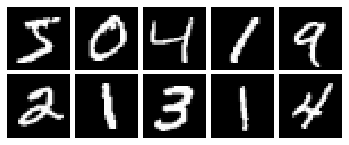

In [5]:
plot_mat(mnist_full_train_data[:10, None], cmap='gray')

In [6]:
class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

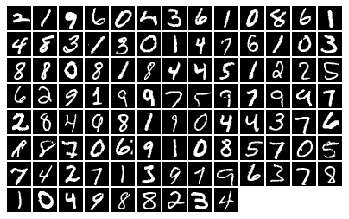

In [7]:
train_loader = InMemDataLoader(
    (mnist_full_train_data, ), batch_size=100, shuffle=True)
test_loader = InMemDataLoader(
    (mnist_test_data, ), batch_size=100, shuffle=False)

batch_x, = next(iter(train_loader))
plot_mat(batch_x.numpy()[:,None,:,:], cmap='gray')

In [8]:
# Hyperparams

inp_dim = batch_x.shape[1:]
g_hid_dim = 500
d_hid_dim = 200
latent_dim = 20

class Generator(torch.nn.Module):
    """Takes an image and produces a latent vector."""
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, g_hid_dim)
        self.fc2 = nn.Linear(g_hid_dim, g_hid_dim)
        self.fc3 = nn.Linear(g_hid_dim, np.prod(inp_dim))
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x.view(-1, batch_x.size(1), batch_x.size(2))

class Discriminator(torch.nn.Module):
    """Takes an image and produces a latent vector."""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(np.prod(inp_dim), d_hid_dim)
        self.fc2 = nn.Linear(d_hid_dim, d_hid_dim)
        self.fc3 = nn.Linear(d_hid_dim, 1)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        drop = self.dropout
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = drop(x)
        x = F.relu(self.fc2(x))
        x = drop(x)
        x = torch.sigmoid(self.fc3(x))
        return x

class GAN(torch.nn.Module):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()
    
    def d_loss(self, x):
        N = x.size(0)
        N2 = 2*N
        z = torch.rand((N, latent_dim), dtype=x.dtype, device=x.device)
        fakes = self.generator(z)
        batch = torch.cat((x, fakes), dim=0)
        probs = self.discriminator(batch)
        tprobs = probs[:N]
        fprobs = probs[N:]
        xent_loss = (tprobs.log().sum() + (1.0 - fprobs).log().sum()) / -N2
        acc = ((tprobs >= 0.5).float().sum() + (fprobs < 0.5).float().sum()) / N2
        stats = {'d_xent': xent_loss.item(), 'd_acc': acc.item()}
        return xent_loss, stats
    
    def g_loss(self, x, non_saturating=True):
        N = x.size(0)
        z = torch.rand((N, latent_dim), dtype=x.dtype, device=x.device)
        fakes = self.generator(z)
        probs = self.discriminator(fakes)
        if non_saturating:
            loss = - probs.log().mean()
        else:
            loss = (1.0 - probs).log().mean()
        stats = {'g_loss': loss.item(), 'g_mean_p': probs.mean().item()}
        return loss, stats, fakes

In [9]:
model = GAN()
d_optimizer = torch.optim.Adam(model.discriminator.parameters(),
                               lr=1e-4, weight_decay=1.0e-3)
g_optimizer = torch.optim.Adam(model.generator.parameters(),
                               lr=1e-4, weight_decay=0)
global_step = 0

In [10]:
model.train()

model.to('cuda')
train_loader.to('cuda')

for epoch in range(100):
    for inum, (batch_x, ) in enumerate(train_loader):
        global_step += 1

        # D-step
        d_optimizer.zero_grad()
        d_loss, d_stats = model.d_loss(batch_x)
        d_loss.backward()
        d_optimizer.step()

        # G-step
        g_optimizer.zero_grad()
        g_loss, g_stats, g_fakes = model.g_loss(batch_x)
        g_loss.backward()
        g_optimizer.step()
        
        if (global_step%500) == 1:
            print("global step: %d d_loss: %f %s, g_loss %f %s" % 
                  (global_step, d_loss.item(), d_stats, g_loss.item(), g_stats))
            plot_mat(n(g_fakes)[:, None])
            plt.show()

Output hidden; open in https://colab.research.google.com to view.

## GAN analysis

Text(0.5, 1.0, 'Samples from a 20 dimensional GAN')

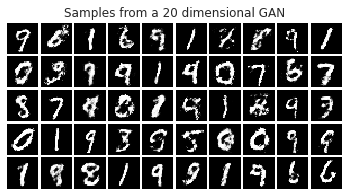

In [11]:
# Lets take a loook at samples generated from the GAN
#

z_rand = torch.rand(50, latent_dim, device=batch_x.device, dtype=batch_x.dtype)
samples = model.generator(z_rand).view(-1, 1, batch_x.size(1), batch_x.size(2))
plot_mat(n(samples), cmap='gray')
plt.title("Samples from a %d dimensional GAN" % latent_dim)

Text(0.5, 1.0, 'interpolation between two samples')

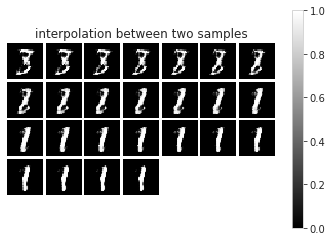

In [12]:
interp_weights = torch.linspace(
    0.0, 1.0, steps=25, dtype=torch.float32, device=batch_x.device).view(-1, 1)
k1, k2 = 2, 33
interp_z = interp_weights * z_rand[k1] + (1.0 - interp_weights) * z_rand[k2]
interp_recs = model.generator(interp_z).view(-1, 1, 28, 28)

plt.figure()
plot_mat(n(interp_recs), cmap='gray')
plt.colorbar()
plt.title('interpolation between two samples')

In [13]:
desired_img = batch_x[0:1]
infer_z = torch.rand((1, latent_dim), dtype=torch.float32, device='cuda', requires_grad=True)
z_optim = torch.optim.Adam([infer_z], lr=1e-1)

for step in range(5000):
    z_optim.zero_grad()
    def closure():
        img = model.generator(infer_z)
        loss = F.binary_cross_entropy(img, desired_img)
        if (step % 1000) == 0:
            print(step, loss.item())
        loss.backward()
        return loss
    z_optim.step(closure)
    with torch.no_grad():
        infer_z.clamp(0,1)
    

0 1.8879090547561646
1000 0.1266641467809677
2000 0.12673525512218475
3000 0.12610696256160736
4000 0.12617288529872894


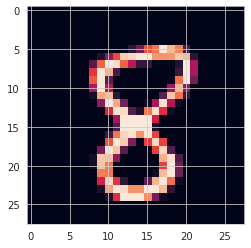

In [14]:
plt.imshow(n(batch_x[0:1])[0])

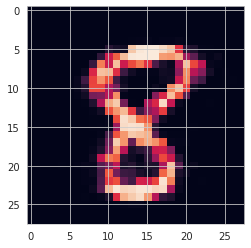

In [15]:
plt.imshow(n(model.generator(infer_z))[0])